# Baseline model
Model pour s'habituer au dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#pip install pandas-profiling
import pandas_profiling
import matplotlib.pyplot as plt
# pip install scikit-plot
import scikitplot as skplt
#pip install missingno
import missingno as msno
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Imputer
%matplotlib inline

#pip install xgboost
import xgboost as xgb
#pip install lightgbm
import lightgbm as lgb
import math
pd.options.display.max_columns = 99

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [3]:
#data_HomeCredit_columns_description = pd.read_csv('../data/HomeCredit_columns_description.csv')


On nettoie le nom des colonnes car, c'est pénible de manipuler les noms avec des majuscules

data_bureau_balance

In [4]:
data_bureau_balance = pd.read_csv('../data/bureau_balance.csv')
data_bureau_balance = reduce_mem_usage(data_bureau_balance)
data_bureau_balance.columns = [str.lower(x) for x in data_bureau_balance.columns]
data_bureau_balance.head()
bureau_bal = data_bureau_balance.groupby('sk_id_bureau').agg(['min','max','mean','std','median','count','sum'])
bureau_bal.columns = ["_".join(x) for x in bureau_bal.columns.ravel()]
bureau_bal.columns = [ 'bureau_bal_' + x for x in bureau_bal.columns]
del(data_bureau_balance)

Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 156.21 MB
Decreased by 75.0%


installments_payments

In [5]:
data_installments_payments = pd.read_csv('../data/installments_payments.csv')
data_installments_payments = reduce_mem_usage(data_installments_payments)
data_installments_payments.columns = [str.lower(x) for x in data_installments_payments.columns]
data_installments_payments.head()
install = data_installments_payments.groupby('sk_id_curr').agg(['min','max','mean','std','median','count','sum'])
install.columns = ["_".join(x) for x in install.columns.ravel()]
install.columns = [ 'install_' + x for x in install.columns]
del(data_installments_payments)

Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 311.40 MB
Decreased by 62.5%


/home/brivael/anaconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:1351: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var(ddof=ddof, **kwargs))


POS_CASH_balance

In [6]:
data_POS_CASH_balance = pd.read_csv('../data/POS_CASH_balance.csv')
data_POS_CASH_balance = reduce_mem_usage(data_POS_CASH_balance)
data_POS_CASH_balance.columns = [str.lower(x) for x in data_POS_CASH_balance.columns]
data_POS_CASH_balance.drop('sk_id_prev',axis=1,inplace=True)
cash = data_POS_CASH_balance.groupby('sk_id_curr').agg(['min','max','mean','std','median','count','sum'])
#On supprime les multi index, et on ajoute un préfixe pour mieux identifier les variables
cash.columns = ["_".join(x) for x in cash.columns.ravel()]
cash.columns = [ 'cash_' + x for x in cash.columns]
del(data_POS_CASH_balance)

Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 171.69 MB
Decreased by 71.9%


bureau

In [7]:
data_bureau = pd.read_csv('../data/bureau.csv')
data_bureau = reduce_mem_usage(data_bureau)
data_bureau.columns = [str.lower(x) for x in data_bureau.columns]

#JOIN
data_bureau = data_bureau.set_index('sk_id_bureau').join(bureau_bal,how='left')
data_bureau.reset_index(inplace=True)
data_bureau.drop('sk_id_bureau',axis=1,inplace=True)

bureau = data_bureau.groupby('sk_id_curr').agg(['min','max','mean','std','median','count','sum'])
bureau.columns = ["_".join(x) for x in bureau.columns.ravel()]
bureau.columns = [ 'bureau_' + x for x in bureau.columns]
del(data_bureau)

Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 78.57 MB
Decreased by 64.7%


/home/brivael/anaconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:1351: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var(ddof=ddof, **kwargs))


credit_card_balance

In [8]:
data_credit_card_balance  = pd.read_csv('../data/credit_card_balance.csv')
data_credit_card_balance = reduce_mem_usage(data_credit_card_balance)
data_credit_card_balance.columns = [str.lower(x) for x in data_credit_card_balance.columns]
card_credit = data_credit_card_balance.groupby('sk_id_curr').agg(['min','max','mean','std','median','count','sum'])
card_credit.columns = ["_".join(x) for x in card_credit.columns.ravel()]
card_credit.columns = [ 'card_credit_' + x for x in card_credit.columns]
del(data_credit_card_balance)

Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 263.69 MB
Decreased by 60.9%


/home/brivael/anaconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:1351: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var(ddof=ddof, **kwargs))


previous_application

In [9]:
data_previous_application = pd.read_csv('../data/previous_application.csv')
data_previous_application = reduce_mem_usage(data_previous_application)
data_previous_application['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
data_previous_application['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)
data_previous_application['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
data_previous_application['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
data_previous_application['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
data_previous_application.columns = [str.lower(x) for x in data_previous_application.columns]
data_previous_application.head()
previous_app = data_previous_application.groupby('sk_id_curr').agg(['min','max','mean','std','median','count','sum'])
previous_app.columns = ["_".join(x) for x in previous_app.columns.ravel()]
previous_app.columns = [ 'previous_app_' + x for x in previous_app.columns]
del(data_previous_application)

Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 130.62 MB
Decreased by 72.3%


/home/brivael/anaconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:1351: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var(ddof=ddof, **kwargs))


Join

In [10]:
bureau_bal.head()

,bureau_bal_months_balance_min,bureau_bal_months_balance_max,bureau_bal_months_balance_mean,bureau_bal_months_balance_std,bureau_bal_months_balance_median,bureau_bal_months_balance_count,bureau_bal_months_balance_sum
sk_id_bureau,,,,,,,
5001709,-96,0,-48.0,28.145456,-48.0,97,-4656.0
5001710,-82,0,-41.0,24.103942,-41.0,83,-3403.0
5001711,-3,0,-1.5,1.290994,-1.5,4,-6.0
5001712,-18,0,-9.0,5.627314,-9.0,19,-171.0
5001713,-21,0,-10.5,6.493587,-10.5,22,-231.0


In [11]:
bureau.head()

,bureau_days_credit_min,bureau_days_credit_max,bureau_days_credit_mean,bureau_days_credit_std,bureau_days_credit_median,bureau_days_credit_count,bureau_days_credit_sum,bureau_credit_day_overdue_min,bureau_credit_day_overdue_max,bureau_credit_day_overdue_mean,bureau_credit_day_overdue_std,bureau_credit_day_overdue_median,bureau_credit_day_overdue_count,bureau_credit_day_overdue_sum,bureau_days_credit_enddate_min,bureau_days_credit_enddate_max,bureau_days_credit_enddate_mean,bureau_days_credit_enddate_std,bureau_days_credit_enddate_median,bureau_days_credit_enddate_count,bureau_days_credit_enddate_sum,bureau_days_enddate_fact_min,bureau_days_enddate_fact_max,bureau_days_enddate_fact_mean,bureau_days_enddate_fact_std,bureau_days_enddate_fact_median,bureau_days_enddate_fact_count,bureau_days_enddate_fact_sum,bureau_amt_credit_max_overdue_min,bureau_amt_credit_max_overdue_max,bureau_amt_credit_max_overdue_mean,bureau_amt_credit_max_overdue_std,bureau_amt_credit_max_overdue_median,bureau_amt_credit_max_overdue_count,bureau_amt_credit_max_overdue_sum,bureau_cnt_credit_prolong_min,bureau_cnt_credit_prolong_max,bureau_cnt_credit_prolong_mean,bureau_cnt_credit_prolong_std,bureau_cnt_credit_prolong_median,bureau_cnt_credit_prolong_count,bureau_cnt_credit_prolong_sum,bureau_amt_credit_sum_min,bureau_amt_credit_sum_max,bureau_amt_credit_sum_mean,bureau_amt_credit_sum_std,bureau_amt_credit_sum_median,bureau_amt_credit_sum_count,bureau_amt_credit_sum_sum,...,bureau_bureau_bal_months_balance_min_min,bureau_bureau_bal_months_balance_min_max,bureau_bureau_bal_months_balance_min_mean,bureau_bureau_bal_months_balance_min_std,bureau_bureau_bal_months_balance_min_median,bureau_bureau_bal_months_balance_min_count,bureau_bureau_bal_months_balance_min_sum,bureau_bureau_bal_months_balance_max_min,bureau_bureau_bal_months_balance_max_max,bureau_bureau_bal_months_balance_max_mean,bureau_bureau_bal_months_balance_max_std,bureau_bureau_bal_months_balance_max_median,bureau_bureau_bal_months_balance_max_count,bureau_bureau_bal_months_balance_max_sum,bureau_bureau_bal_months_balance_mean_min,bureau_bureau_bal_months_balance_mean_max,bureau_bureau_bal_months_balance_mean_mean,bureau_bureau_bal_months_balance_mean_std,bureau_bureau_bal_months_balance_mean_median,bureau_bureau_bal_months_balance_mean_count,bureau_bureau_bal_months_balance_mean_sum,bureau_bureau_bal_months_balance_std_min,bureau_bureau_bal_months_balance_std_max,bureau_bureau_bal_months_balance_std_mean,bureau_bureau_bal_months_balance_std_std,bureau_bureau_bal_months_balance_std_median,bureau_bureau_bal_months_balance_std_count,bureau_bureau_bal_months_balance_std_sum,bureau_bureau_bal_months_balance_median_min,bureau_bureau_bal_months_balance_median_max,bureau_bureau_bal_months_balance_median_mean,bureau_bureau_bal_months_balance_median_std,bureau_bureau_bal_months_balance_median_median,bureau_bureau_bal_months_balance_median_count,bureau_bureau_bal_months_balance_median_sum,bureau_bureau_bal_months_balance_count_min,bureau_bureau_bal_months_balance_count_max,bureau_bureau_bal_months_balance_count_mean,bureau_bureau_bal_months_balance_count_std,bureau_bureau_bal_months_balance_count_median,bureau_bureau_bal_months_balance_count_count,bureau_bureau_bal_months_balance_count_sum,bureau_bureau_bal_months_balance_sum_min,bureau_bureau_bal_months_balance_sum_max,bureau_bureau_bal_months_balance_sum_mean,bureau_bureau_bal_months_balance_sum_std,bureau_bureau_bal_months_balance_sum_median,bureau_bureau_bal_months_balance_sum_count,bureau_bureau_bal_months_balance_sum_sum
sk_id_curr,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,-1572,-49,-735.000000,489.942514,-857.0,7,-5145.0,0,0,0.0,0.0,0.0,7,0,-1329.0,1778.0,82.4375,inf,-179.0,7,577.0,-1328.0,-544.0,-825.5,inf,-715.0,4,-3302.0,NaN,NaN,NaN,NaN,NaN,0,0.000000,0,0,0.0,0.0,0.0,7,0,85500.0,378000.000000,207623.578125,122544.546875,168345.000000,7,1.453365e+06,...,-51.0,-1.0,-23.571429,16.050515,-

In [12]:
data_application_test = pd.read_csv('../data/application_test.csv')
data_application_train = pd.read_csv('../data/application_train.csv')
data_pool = data_application_train.append(data_application_test)
data_pool = reduce_mem_usage(data_pool)
del(data_application_test)
del(data_application_train)
data_pool.columns = [str.lower(x) for x in data_pool.columns]

data_pool = data_pool.set_index('sk_id_curr').join(cash,how='left')
data_pool = data_pool.join(bureau,how='left')
data_pool = data_pool.join(card_credit,how='left')
data_pool = data_pool.join(install,how='left')

del(cash)
del(bureau)
del(card_credit)
del(install)

/home/brivael/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


Memory usage of dataframe is 334.32 MB
Memory usage after optimization is: 72.03 MB
Decreased by 78.5%


### Analyse 

## Data cleaning

Très simple on transforme toutes les variables qualitatives en variables booléenne.

In [13]:
data_cleaned = pd.get_dummies(data_pool)
data_cleaned = data_cleaned.reset_index()

In [14]:
data_cleaned.head()

,sk_id_curr,amt_annuity,amt_credit,amt_goods_price,amt_income_total,amt_req_credit_bureau_day,amt_req_credit_bureau_hour,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_week,amt_req_credit_bureau_year,apartments_avg,apartments_medi,apartments_mode,basementarea_avg,basementarea_medi,basementarea_mode,cnt_children,cnt_fam_members,commonarea_avg,commonarea_medi,commonarea_mode,days_birth,days_employed,days_id_publish,days_last_phone_change,days_registration,def_30_cnt_social_circle,def_60_cnt_social_circle,elevators_avg,elevators_medi,elevators_mode,entrances_avg,entrances_medi,entrances_mode,ext_source_1,ext_source_2,ext_source_3,flag_cont_mobile,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,...,organization_type_Industry: type 6,organization_type_Industry: type 7,organization_type_Industry: type 8,organization_type_Industry: type 9,organization_type_Insurance,organization_type_Kindergarten,organization_type_Legal Services,organization_type_Medicine,organization_type_Military,organization_type_Mobile,organization_type_Other,organization_type_Police,organization_type_Postal,organization_type_Realtor,organization_type_Religion,organization_type_Restaurant,organization_type_School,organization_type_Security,organization_type_Security Ministries,organization_type_Self-employed,organization_type_Services,organization_type_Telecom,organization_type_Trade: type 1,organization_type_Trade: type 2,organization_type_Trade: type 3,organization_type_Trade: type 4,organization_type_Trade: type 5,organization_type_Trade: type 6,organization_type_Trade: type 7,organization_type_Transport: type 1,organization_type_Transport: type 2,organization_type_Transport: type 3,organization_type_Transport: type 4,organization_type_University,organization_type_XNA,wallsmaterial_mode_Block,wallsmaterial_mode_Mixed,wallsmaterial_mode_Monolithic,wallsmaterial_mode_Others,wallsmaterial_mode_Panel,"wallsmaterial_mode_Stone, brick",wallsmaterial_mode_Wooden,weekday_appr_process_start_FRIDAY,weekday_appr_process_start_MONDAY,weekday_appr_process_start_SATURDAY,weekday_appr_process_start_SUNDAY,weekday_appr_process_start_THURSDAY,weekday_appr_process_start_TUESDAY,weekday_appr_process_start_WEDNESDAY
0,100002,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,0.024704,0.024994,0.025208,0.036896,0.036896,0.038300,0,1.0,0.014297,0.014397,0.014397,-9461,-637,-2120,-1134.0,-3648.0,2.0,2.0,0.000000,0.000000,0.000000,0.068970,0.068970,0.068970,0.083008,0.262939,0.139404,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,100003,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.095886,0.096802,0.092407,0.052887,0.052887,0.053802,0,2.0,0.060486,0.060791,0.049713,-16765,-1188,-291,-828.0,-1186.0,0.0,0.0,0.080017,0.080017,0.080627,0.034485,0.034485,0.034485,0.311279,0.622070,NaN,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,100004,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,NaN,NaN,NaN,-19046,-225,-2531,-815.0,-4260.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.556152,0.729492,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,100006,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0,NaN,NaN,NaN,-19005,-3039,-2437,-617.0,-9832.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.650391,NaN,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,100007,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,NaN,NaN,NaN,-19932,-3038,-3458,-1106.0,-4312.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.322754,NaN,1,0,0,0,0,0,0,0,0,0,

### Feature Selection
Chris Albon

Seuil à modifier si besoin. Pour l'instant le suppression des variables sembles baisser les perf du modèle

In [15]:
data_cleaned['credit_income_percent'] = data_cleaned['amt_credit'] / data_cleaned['amt_income_total']
data_cleaned['annuity_income_percent'] = data_cleaned['amt_annuity'] / data_cleaned['amt_income_total']
data_cleaned['credit_term'] = data_cleaned['amt_annuity'] / data_cleaned['amt_credit']
data_cleaned['days_employed_percent'] = data_cleaned['days_employed'] / data_cleaned['days_birth']
data_cleaned['annuity_length'] = data_cleaned['amt_credit'] / data_cleaned['amt_annuity']
data_cleaned['new_credit_to_goods_ratio'] = data_cleaned['amt_credit'] / data_cleaned['amt_goods_price']
data_cleaned['income_per_person'] = data_cleaned['amt_income_total'] / data_cleaned['cnt_fam_members']
data_cleaned['income_credit_perc'] = data_cleaned['amt_income_total'] / data_cleaned['amt_credit']
data_cleaned['annuity_income_perc'] = np.sqrt(data_cleaned['amt_annuity'] / (1 + data_cleaned['amt_income_total']))
data_cleaned['children_ratio'] = data_cleaned['cnt_children'] / data_cleaned['cnt_fam_members']
data_cleaned['inc_per_child'] = data_cleaned['amt_income_total'] / (1 + data_cleaned['cnt_children'])
data_cleaned['sources_prod'] = data_cleaned['ext_source_1'] * data_cleaned['ext_source_2'] * data_cleaned['ext_source_3']
data_cleaned['car_to_birth_ratio'] = data_cleaned['own_car_age'] / data_cleaned['days_birth']
data_cleaned['car_to_employ_ratio'] = data_cleaned['own_car_age'] / data_cleaned['days_employed']
data_cleaned['phone_to_birth_ratio'] = data_cleaned['days_last_phone_change'] / data_cleaned['days_birth']
data_cleaned['phone_to_employ_ratio'] = data_cleaned['days_last_phone_change'] / data_cleaned['days_employed'] 

In [16]:
data_cleaned.drop(['bureau_days_credit_enddate_std', 'bureau_days_credit_enddate_sum',
        'bureau_days_enddate_fact_std', 'bureau_days_enddate_fact_sum',
        'install_days_instalment_std', 'install_days_instalment_sum',
        'install_days_entry_payment_std', 'install_days_entry_payment_sum'],axis=1,inplace=True)

corr_matrix = data_cleaned.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.97)]
data_cleaned.drop(columns=to_drop,axis=1,inplace=True)

test = data_cleaned[data_cleaned.target.isnull()]
train = data_cleaned[data_cleaned.target.notnull()]

del(data_pool)
del(data_cleaned)

## Modèle

Regression logistique pour commencer.  
Les prochain modèles à tester seront :
- Xgboost
- LightGBM

In [17]:
train = reduce_mem_usage(train)
train.fillna(train.median(),inplace=True)

Memory usage of dataframe is 454.85 MB
Memory usage after optimization is: 320.54 MB
Decreased by 29.5%


In [18]:
c = train.columns
train.dropna(axis=1,how='all',inplace=True)
train = np.nan_to_num(train)
train = pd.DataFrame(train)
train.columns = c

In [19]:
np.where(train.values >= np.finfo(np.float64).max)

(array([], dtype=int64), array([], dtype=int64))

In [20]:
np.where(train.isnull() == True)

(array([], dtype=int64), array([], dtype=int64))

In [21]:
target = train.target
#On drop l'ID mais je n'ai pas vérifier s'il influe sur le résultat
train = train.drop(['sk_id_curr','target'],axis=1)
col = train.columns

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train = scaler.fit_transform(train)
train = pd.DataFrame(train)
train.columns = col

/home/brivael/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:116: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Split du dataset d'entrainement. Un set de validation sera crée par la suite

In [23]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.4, random_state=1)

Baseline LogReg

In [24]:
# regleg = LogisticRegression()
# pred = regleg.fit(X_train,y_train).predict_proba(X_test)

In [25]:
# print(roc_auc_score(y_test, pred[:,1]))
# # print(cross_val_score(LogisticRegression(),X_train,y_train,cv = 5,scoring='roc_auc'))

In [26]:
# skplt.metrics.plot_roc(y_test, pred)

Models

In [27]:
xgbb = xgb.XGBClassifier()
prediction_xgb = xgbb.fit(X_train,y_train).predict_proba(X_test)
print(roc_auc_score(y_test, prediction_xgb[:,1]))
# print(cross_val_score(xgb.XGBClassifier(),X_train,y_train,cv = 15,scoring='roc_auc'))

0.7712086663366978


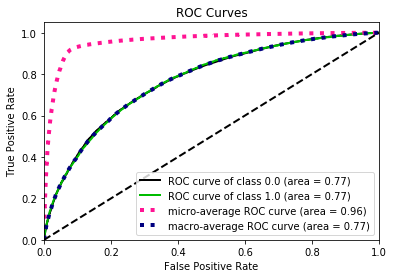

In [28]:
skplt.metrics.plot_roc(y_test, prediction_xgb)

In [29]:
# lightgbm = lgb.LGBMClassifier()
# prediction_lgb = lightgbm.fit(X_train,y_train).predict_proba(X_test)
# print(roc_auc_score(y_test, pred[:,1]))
# # print(cross_val_score(lgb.LGBMClassifier(),X_train,y_train,cv = 15,scoring='roc_auc'))

In [30]:
# skplt.metrics.plot_roc(y_test, prediction_lgb)

In [31]:
# lgb.plot_importance(lightgbm,max_num_features=40)

## Submission  
Il manque des occurence pour le dataset test. On rajoute donc les colonnes du dataset d'entrainement dans celui du test.

In [32]:
data_sample_submission = pd.read_csv('../data/sample_submission.csv')

In [33]:
test.dropna(axis=1,how='all',inplace=True)
c = test.columns
test = np.nan_to_num(test)
test = pd.DataFrame(test)
test.columns = c

In [34]:
test.head()

,sk_id_curr,amt_annuity,amt_credit,amt_income_total,amt_req_credit_bureau_day,amt_req_credit_bureau_hour,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_week,amt_req_credit_bureau_year,apartments_avg,basementarea_avg,cnt_children,cnt_fam_members,commonarea_avg,days_birth,days_employed,days_id_publish,days_last_phone_change,days_registration,def_30_cnt_social_circle,def_60_cnt_social_circle,elevators_avg,entrances_avg,ext_source_1,ext_source_2,ext_source_3,flag_cont_mobile,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_2,flag_document_20,flag_document_21,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_email,...,organization_type_Realtor,organization_type_Religion,organization_type_Restaurant,organization_type_School,organization_type_Security,organization_type_Security Ministries,organization_type_Self-employed,organization_type_Services,organization_type_Telecom,organization_type_Trade: type 1,organization_type_Trade: type 2,organization_type_Trade: type 3,organization_type_Trade: type 4,organization_type_Trade: type 5,organization_type_Trade: type 6,organization_type_Trade: type 7,organization_type_Transport: type 1,organization_type_Transport: type 2,organization_type_Transport: type 3,organization_type_Transport: type 4,organization_type_University,wallsmaterial_mode_Block,wallsmaterial_mode_Mixed,wallsmaterial_mode_Monolithic,wallsmaterial_mode_Others,wallsmaterial_mode_Panel,"wallsmaterial_mode_Stone, brick",wallsmaterial_mode_Wooden,weekday_appr_process_start_FRIDAY,weekday_appr_process_start_MONDAY,weekday_appr_process_start_SATURDAY,weekday_appr_process_start_SUNDAY,weekday_appr_process_start_THURSDAY,weekday_appr_process_start_TUESDAY,weekday_appr_process_start_WEDNESDAY,credit_income_percent,annuity_income_percent,credit_term,annuity_length,new_credit_to_goods_ratio,income_per_person,income_credit_perc,children_ratio,inc_per_child,sources_prod,car_to_birth_ratio,car_to_employ_ratio,phone_to_birth_ratio,phone_to_employ_ratio
0,100001.0,20560.5,568800.0,135000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.065979,0.058990,0.0,2.0,0.000000,-19241.0,-2329.0,-812.0,-1740.0,-5168.0,0.0,0.0,0.000000,0.137939,0.752441,0.789551,0.159546,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.213333,0.152300,0.036147,27.664698,1.2640,67500.0,0.237342,0.000000,135000.0,0.094788,0.000000,0.000000,0.090432,0.747102
1,100005.0,17370.0,222768.0,99000.0,0.0,0.0,0.0,0.0,0.0,3.0,0.000000,0.000000,0.0,2.0,0.000000,-18064.0,-4469.0,-1623.0,0.0,-9120.0,0.0,0.0,0.000000,0.000000,0.564941,0.291748,0.432861,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.250182,0.175455,0.077973,12.824870,1.2376,49500.0,0.444409,0.000000,99000.0,0.071350,0.000000,0.000000,-0.000000,-0.000000
2,100013.0,69777.0,663264.0,202500.0,0.0,0.0,0.0,1.0,0.0,4.0,0.000000,0.000000,0.0,2.0,0.000000,-20038.0,-4458.0,-3503.0,-856.0,-2176.0,0.0,0.0,0.000000,0.000000,0.000000,0.699707,0.610840,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.275378,0.344578,0.105202,9.505482,1.0528,101250.0,0.305308,0.000000,202500.0,0.000000,-0.000250,-0.001122,0.042719,0.192014
3,100028.0,49018.5,1575000.0,315000.0,0.0,0.0,0.0,0.0,0.0,3.0,0.305176,0.197388,2.0,4.0,0.116516,-13976.0,-1866.0,-4208.0,-1805.0,-2000.0,0.0,0.0,0.320068,0.275879,0.

In [35]:
data_sample_submission.head()

,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5
2,100013,0.5
3,100028,0.5
4,100038,0.5


In [36]:
# test.reset_index(inplace=True)
test.drop(['sk_id_curr'],axis=1,inplace=True)
test.fillna(test.median(),inplace=True)
c_test = test.columns
test = scaler.fit_transform(test)
test = pd.DataFrame(test)
test.columns = c_test

In [37]:
prediction = xgbb.predict_proba(test)
data_sample_submission['TARGET'] = prediction[:,1]

In [38]:
data_sample_submission.to_csv('SimpleFeatures.csv',index=False)